#Uploading the **Bank Data** from local disk

---
* Title: Bank Marketing (with socio-economic context)

* Sources
   Created by: Sérgio Moro (ISCTE-IUL), Paulo Cortez (Univ. Minho) and Paulo Rita (ISCTE-IUL) @ 2014

* Number of Instances: 41188 for bank-additional-full.csv

* Number of Attributes: 20 + output attribute.

---

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bank-additional-full.csv to bank-additional-full.csv


# Importing Libraries

---


*   **pandas, numpy, seaborn & matplotlib** are used for dataframe/vector manipulatiion and visualisation.

*   The **preprocessing** library from sklearn is used to encode attributes from the dataframe into mathematical forms that are suitable for our models to work upon.
*   The **model selection** library from sklearn is used to choose the optimal tree depth and to split our data into testing and traing parts.
*   Model **RandomForestClassifier** an ensemble learning method is directly imported from sklearn and implented on the encoded data.
*   The **metrics** library from sklearn is used to analyse and compare the models.
---


In [ ]:
import io
import os
import timeit
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

# Importing the data into a dataframe

---

The dataframe has the attributes:

* Bank client data:

      1 - age (numeric)
      2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed", "services","student","technician","unemployed","unknown")
      3 - marital : marital status (categorical: "divorced","married","single","unknown")
      4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
      5 - default: has credit in default? (categorical: "no","yes","unknown")
      6 - housing: has housing loan? (categorical: "no","yes","unknown")
      7 - loan: has personal loan? (categorical: "no","yes","unknown")
* Data related with the last contact of the current campaign:

      8 - contact: contact communication type (categorical: "cellular","telephone") 
      9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
      10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
      11 - duration: last contact duration, in seconds (numeric).

* Other attributes:

      12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
      13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
      14 - previous: number of contacts performed before this campaign and for this client (numeric)
      15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

* Social and economic context attributes:

      16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
      17 - cons.price.idx: consumer price index - monthly indicator (numeric)     
      18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
      19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
      20 - nr.employed: number of employees - quarterly indicator (numeric)

* The output variable (desired target):

      21 - y - has the client subscribed a term deposit? (binary: "yes","no")

Notes - 

1. The attribute 'previous' is highly volatile and adversely affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed but after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
2. Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. 

---

In [ ]:
df = pd.read_csv("bank-additional-full.csv", sep = ';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Data visualisation & evaluation

---
Before preprocessing, we evaluate some of the attributes in order to decide what to do with them and how to process them -

* First we look at our output attribute (y) and plot a chart for it. It reveals that an overwhelming majority (about 87%%) of the clients who took part in the campaign, did not go though with the the deposit being advertised.
* Attribute 'pdays' is heavily biased towards there being no prior contact to the client, so we will ignore it later on since it can only lead to negligible information gain.
* A heatmap of the numerical attributes reveals that the socio-economic attributes show high levels of corelation and are hence not truly independent. 
* Counts of the categorical attributes reveal how the attribute values are distributed. Most of the attributes have a clear minority (usually 'unknown'), which we later on ignore due to its ambiguous nature.
---

In [ ]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


no     36548
yes     4640
Name: y, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


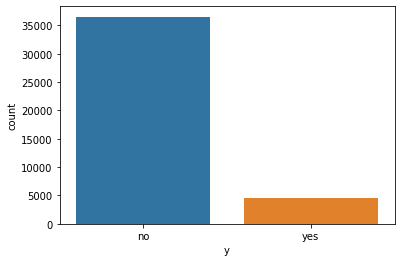

In [ ]:
print(df.y.value_counts())
print(sns.countplot(x='y', data=df))

999    39673
3        439
6        412
4        118
9         64
Name: pdays, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


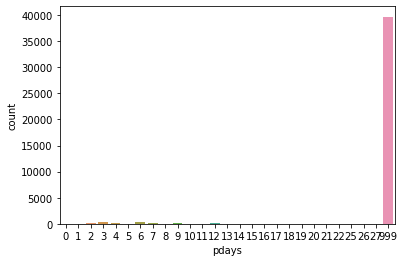

In [ ]:
print(df.pdays.value_counts().head())
print(sns.countplot(x='pdays', data=df))

AxesSubplot(0.125,0.125;0.62x0.755)


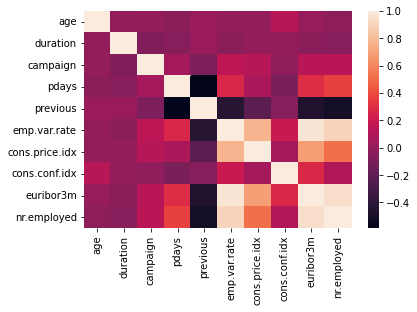

In [ ]:
print(sns.heatmap(df.corr()))

In [ ]:
print("The values of the attribute CONTACT are:\n ",df.contact.value_counts())
print("\nThe values of the attribute HOUSING are:\n ",df.housing.value_counts())
print("\nThe values of the attribute LOAN are:\n ",df.loan.value_counts())
print("\nThe values of the attribute POUTCOME are:\n ",df.poutcome.value_counts())
print("\nThe values of the attribute MARITAL are:\n ",df.marital.value_counts())
print("\nThe values of the attribute DAY_OF_WEEK are:\n ",df.day_of_week.value_counts())
print("\nThe values of the attribute EDUCATION are:\n ",df.education.value_counts())
print("\nThe values of the attribute MONTH are:\n ",df.month.value_counts())
print("\nThe values of the attribute JOB are:\n ",df.job.value_counts())

The values of the attribute CONTACT are:
  cellular     26144
telephone    15044
Name: contact, dtype: int64

The values of the attribute HOUSING are:
  yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

The values of the attribute LOAN are:
  no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

The values of the attribute POUTCOME are:
  nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64

The values of the attribute MARITAL are:
  married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

The values of the attribute DAY_OF_WEEK are:
  thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64

The values of the attribute EDUCATION are:
  university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown   

# Data Preprocessing

---
A stepwise breakdown of the preprocessing - 

1. Drop attributes 'duration' and 'pdays', since their inclusion results in abnormally deep trees which overfit the data. 

2. After that drop entries with values which have a very low percentage share in the distributuion of some attribute in order to avoid very specific leaf nodes that represent them.

3. Then normalise all the numerical attributes to overcome the differences that arise due to the range of values or  measurement units.

4. For the categorical attributes we simply do a one hot encoding in order to transform them to a form that is suitable for the models to work upon.
---


In [ ]:
df = df.drop(['duration', 'pdays'], axis = 1)
df = df[df.job != 'unknown']
df = df[df.default != 'unknown']
df = df[df.marital != 'unknown']
df = df[df.loan != 'unknown']
df = df[df.education != 'illiterate']
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
df_num=df.select_dtypes(include=np.number)
ss = StandardScaler()
num_scaled = ss.fit_transform(df_num)
X = pd.DataFrame(num_scaled, columns = df_num.columns)
X.head()

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.613790,-0.560453,-0.372886,0.730651,0.799058,0.870008,0.789734,0.407739
1,-0.202245,-0.560453,-0.372886,0.730651,0.799058,0.870008,0.789734,0.407739
2,0.084497,-0.560453,-0.372886,0.730651,0.799058,0.870008,0.789734,0.407739
3,1.613790,-0.560453,-0.372886,0.730651,0.799058,0.870008,0.789734,0.407739
4,1.900532,-0.560453,-0.372886,0.730651,0.799058,0.870008,0.789734,0.407739


In [ ]:
df_cat=df.select_dtypes(exclude=np.number)
df_cat=df_cat.drop('y',axis=1)
df_cat.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent
6,admin.,married,professional.course,no,no,no,telephone,may,mon,nonexistent


In [ ]:
X_encode=pd.get_dummies(df_cat,columns=df_cat.columns)
X_encode.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_professional.course,education_university.degree,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
6,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


In [ ]:
X.reset_index(drop = True, inplace = True)
X_encode.reset_index(drop = True, inplace = True)
x = pd.concat([X, X_encode], axis = 1)
x.head()

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_professional.course,education_university.degree,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,1.613790,-0.560453,-0.372886,0.730651,0.799058,0.870008,0.789734,0.407739,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,-0.202245,-0.560453,-0.372886,0.730651,0.799058,0.870008,0.789734,0.407739,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,0.084497,-0.560453,-0.372886,0.730651,0.799058,0.870008,0.789734,0.407739,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,1.613790,-0.560453,-0.372886,0.730651,0.799058,0.870008,0.789734,0.407739,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,1.900532,-0.560453,-0.372886,0.730651,0.799058,0.870008,0.789734,0.407739,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


# Splitting the data

---
* A standard teest-train split has been implemented here.
* 0.25 was chosen since it consistently provided enough varience to produce relatively smaller trees.
---

In [ ]:
y=df['y']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

# Building the Random Forest

---
A stepwise breakdown of the forest building process-
1. Similart to the decision tree methodology, we use GridSearchCV in order to find the optimal tree depth and optimal number of trees in order to produce a well fitted ensemble model.
2. Then we use the optimal values to fit the training data using the RandomForestClassifier from sklearn.
3. Finally we use the forest to predict the output for the test data.  
---

In [ ]:
depth = [1, 5, 10, 50, 100, 500]
n_estimators =  [5, 10, 20, 40, 50, 60, 80, 100, 200]
param_grid={'n_estimators':n_estimators , 'max_depth':depth}
clf = RandomForestClassifier()
RF_model = GridSearchCV(clf,param_grid,scoring='roc_auc',n_jobs=-1,cv=3)
RF_model.fit(X_train,y_train)
best_n_estimators = RF_model.best_estimator_.n_estimators
best_max_depth = RF_model.best_estimator_.max_depth
print("Optimal value of n_estimators",best_n_estimators)
print("Optimal value of max_depth",best_max_depth)

Optimal value of n_estimators 200
Optimal value of max_depth 10


In [ ]:
start = timeit.timeit() 
RF = RandomForestClassifier(n_estimators = best_n_estimators, max_depth = best_max_depth)
RF.fit(X_train,y_train)
end = timeit.timeit() 
print(end - start )

y_pred = RF.predict(X_test)
y_pred_proba =RF.predict_proba(X_test)[:,1]

-0.009959084999991319


# Random Forest evaluation

---
* The confusion matrix for the respective model is used to calculate the specificity and sensitivity. Sklearn has inbuilt functions for accuracy and auc scores, which we utilise as is.
* Just like the single tree case, the ensemble model also captures a large amount of y='no' but is pretty bad at predicing the y='yes' cases. Also intersting to note is that the accuracy of our model is only marginally better than the original 87% we had.
---

In [ ]:
cm_RF = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm_RF.ravel()
specificity_RF = tn / (tn+fp)
sensitivity_RF = tp / (tp+fn)
accuracy_RF = accuracy_score(y_test, y_pred)
roc_RF = roc_auc_score(y_test, y_pred_proba)

print('Confusion Matrix: \n', cm_RF)
print('Specificity: \n', specificity_RF)
print('Sensitivity: \n', sensitivity_RF)
print('Accuracy: \n', accuracy_RF)
print("AUC score: \n", roc_RF)

report_RF = classification_report(y_test, y_pred)
print('\nSummary: \n', report_RF)

Confusion Matrix: 
 [[6715  134]
 [ 780  266]]
Specificity: 
 0.9804351000146007
Sensitivity: 
 0.25430210325047803
Accuracy: 
 0.8842305256491451
AUC score: 
 0.8182244997036594

Summary: 
               precision    recall  f1-score   support

          no       0.90      0.98      0.94      6849
         yes       0.67      0.25      0.37      1046

    accuracy                           0.88      7895
   macro avg       0.78      0.62      0.65      7895
weighted avg       0.87      0.88      0.86      7895

